In [1]:
import tensorflow
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import joblib

In [2]:


health_data =  pd.read_csv('../merged_final_data_heavy_filtered.csv')

In [3]:
print(health_data.columns)

Index(['Age', 'Gender', 'Race', 'Tobacco smoking status NHIS',
       'Pain severity - 0-10 verbal numeric rating [Score] - Reported',
       'Heart rate', 'Body Height', 'Body Weight', 'Body Mass Index',
       'Hemoglobin [Mass/volume] in Blood', 'Systolic Blood Pressure',
       'Diastolic Blood Pressure',
       'Stress is when someone feels tense  nervous  anxious or can't sleep at night because their mind is troubled. How stressed are you?',
       'Hypertension'],
      dtype='object')


In [4]:
columns_to_encode = ['Tobacco smoking status NHIS',  
                    "Stress is when someone feels tense  nervous  anxious or can't sleep at night because their mind is troubled. How stressed are you?", 
                    "Gender", 
                     "Race"]
OHE    = OneHotEncoder(sparse=False)
encoded_columns =    OHE.fit_transform(health_data[columns_to_encode])
joblib.dump(OHE, '../weights/encoder.joblib')
                     
                     

['../weights/encoder.joblib']

In [5]:
only_scalar = health_data.drop(columns_to_encode, axis=1)

unique, counts = np.unique(only_scalar['Hypertension'].values, return_counts=True)
print("train:",dict(zip(unique, counts)))

train: {0: 36700, 1: 8759}


In [6]:
processed_data = np.concatenate([encoded_columns,only_scalar.values], axis=1)

In [7]:
print(processed_data.shape)

(45459, 27)


In [8]:
unique, counts = np.unique(processed_data[:,-1], return_counts=True)
print("train:",dict(zip(unique, counts)))

train: {0.0: 36700, 1.0: 8759}


Shuffle the dataset.

In [9]:
from sklearn.utils import shuffle

processed_data = shuffle(processed_data)

In [10]:
X = processed_data[:,:-1].astype(float)
y = processed_data[:,-1].astype(int)

In [11]:
hyper_label = list(np.where(y==1)[0])
len(hyper_label)

8759

In [20]:
non_hyper_label = np.where(y==0)[0]
new_non_hyper_label = list(np.random.choice(non_hyper_label, size = int(len(hyper_label))))


In [21]:
new_label_indices = hyper_label + new_non_hyper_label
new_label_indices[0]

1

In [22]:
y_balanced = y[new_label_indices]
X_balanced =X[new_label_indices]


X_balanced, y_balanced =shuffle(X_balanced, y_balanced)
print(y_balanced)

[0 0 0 ... 0 0 0]


In [23]:
 X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.1)

In [24]:
X_train[0].shape[0]

26

In [25]:
print(X_train.dtype)

float64


In [26]:
print(y_train)

[1 1 1 ... 0 0 1]


Fully connected neural network model with 3 hidden layers:

In [27]:
import tensorflow as tf 



def create_model(X):
    model = tf.keras.models.Sequential([
      tf.keras.Input(shape=(X[0].shape[0],)), #Xtrain[0].shape[0] = 108 -> input size
      tf.keras.layers.Dense(128, activation='relu'), #represents 1st hidden layer 
      tf.keras.layers.Dropout(0.2), # dropout regularization with dropout probability 20% percent
      tf.keras.layers.Dense(128, activation='relu'), #represents the 2nd hidden layer 
      tf.keras.layers.Dropout(0.2), # dropout regularization with dropout probability 20% percent
      tf.keras.layers.Dense(128, activation='relu'), #represents the 3rd hidden layer 
      tf.keras.layers.Dropout(0.2), # dropout regularization with dropout probability 20% percent
      tf.keras.layers.Dense(1, activation='sigmoid') # sigmoid activation at output since it is binary classification
    ])
    
    model.compile(optimizer='adam', 
              loss='binary_crossentropy',
              metrics=['accuracy'])
    
    return model

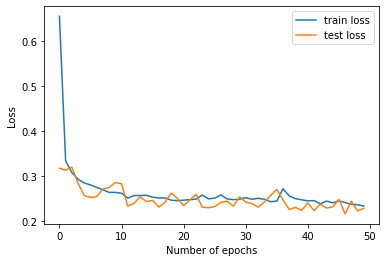

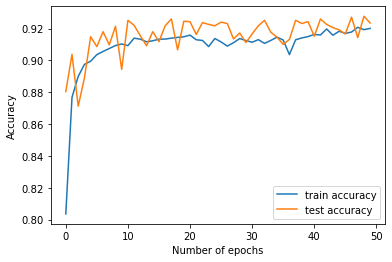

Results of the Fold 1:
110/110 [==============================] - 0s 761us/step - loss: 0.2290 - accuracy: 0.9235
[0.22903099656105042, 0.9235159754753113]
Confusion Matrix:


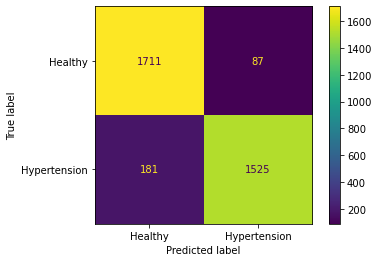

___________________________________________________


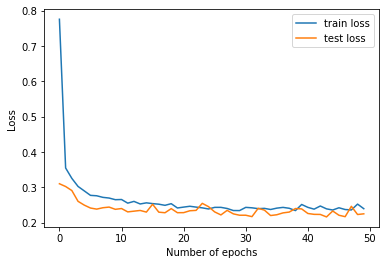

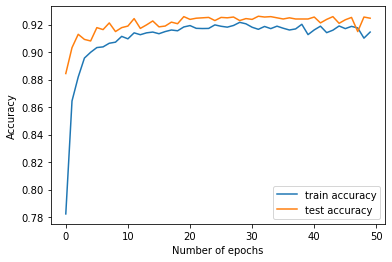

Results of the Fold 2:
110/110 [==============================] - 0s 661us/step - loss: 0.2254 - accuracy: 0.9247
[0.22541512548923492, 0.9246575236320496]
Confusion Matrix:


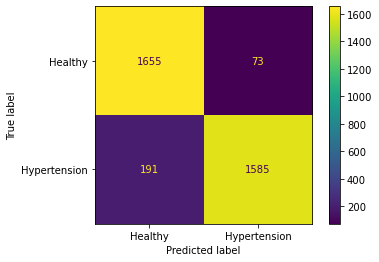

___________________________________________________


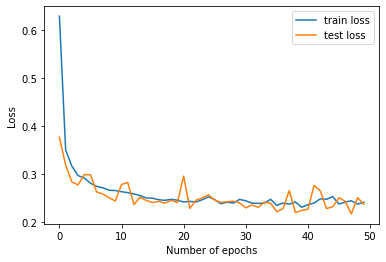

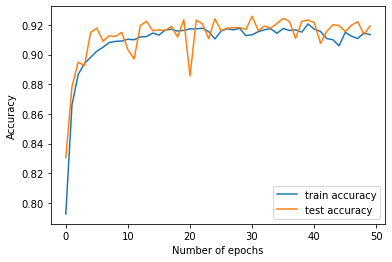

Results of the Fold 3:
110/110 [==============================] - 0s 615us/step - loss: 0.2380 - accuracy: 0.9192
[0.2380496859550476, 0.9192351698875427]
Confusion Matrix:


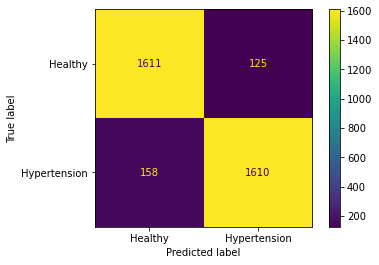

___________________________________________________


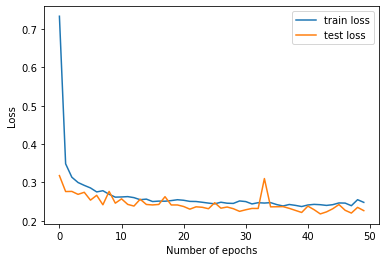

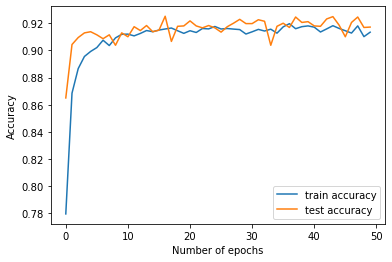

Results of the Fold 4:
110/110 [==============================] - 0s 578us/step - loss: 0.2266 - accuracy: 0.9172
[0.22660480439662933, 0.9172137975692749]
Confusion Matrix:


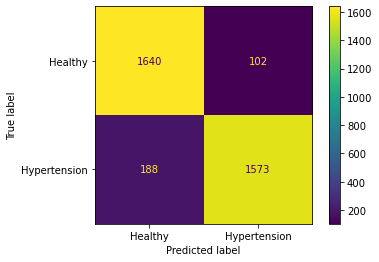

___________________________________________________


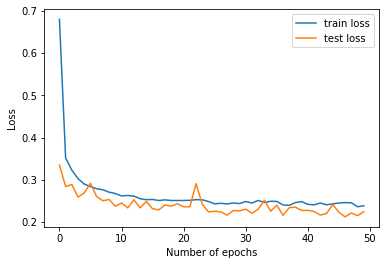

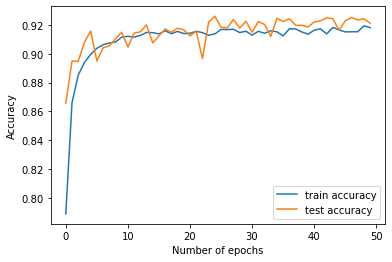

Results of the Fold 5:
110/110 [==============================] - 0s 670us/step - loss: 0.2245 - accuracy: 0.9212
[0.22449037432670593, 0.9212104082107544]
Confusion Matrix:


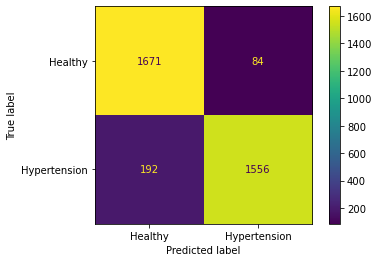

___________________________________________________
Average f-beta score for 5-fold Cross-Validation: 0.922
Average Test Accuracy for 5-fold Cross-Validation: 0.921
Average Confusion Matrix for 5-fold Cross-Validation:


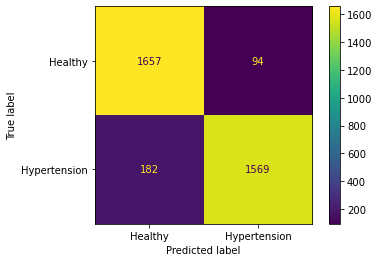

In [28]:
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, fbeta_score
from sklearn.preprocessing import StandardScaler

kf = KFold(n_splits=5)

fold_count = 0
accuracies = []
confusions = []

scaler = StandardScaler()
f_betas = []

for train_index, test_index in kf.split(X_balanced):
    fold_count += 1
    X_train, X_test = X_balanced[train_index], X_balanced[test_index]
    y_train, y_test = y_balanced[train_index], y_balanced[test_index]
    
    model =create_model(X_train)
    r2 =model.fit(X_train, y_train, validation_data=(X_test,y_test), epochs = 50, verbose= 0)

    plt.plot(r2.history['loss'], label='train loss')
    plt.plot(r2.history['val_loss'], label='test loss')
    plt.xlabel("Number of epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()
    
    plt.plot(r2.history['accuracy'], label='train accuracy')
    plt.plot(r2.history['val_accuracy'], label='test accuracy')
    plt.xlabel("Number of epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()
    
    accuracies.append(r2.history['val_accuracy'][-1])
    
    print("Results of the Fold " +str(fold_count) + ":")
    print(model.evaluate(X_test, y_test))
    y_pred = model.predict(X_test)
    
    
    y_pred[y_pred <= 0.5] = 0
    y_pred[y_pred > 0.5] = 1
    print("Confusion Matrix:")
    
    f_betas.append(fbeta_score(y_test, y_pred, average='weighted', beta=0.5))
    
    cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
    confusions.append(cm)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=['Healthy', 'Hypertension'])
    disp.plot()

    plt.show()
    print("___________________________________________________")
    

    
print("Average f-beta score for 5-fold Cross-Validation:", round(sum(f_betas) / fold_count , 3) )
print("Average Test Accuracy for 5-fold Cross-Validation:", round(sum(accuracies) / fold_count , 3) )
avg_confusion = (sum(confusions) / fold_count).astype('int')

disp = ConfusionMatrixDisplay(confusion_matrix=avg_confusion,
display_labels=['Healthy', 'Hypertension'])

print("Average Confusion Matrix for 5-fold Cross-Validation:")
disp.plot()

plt.show()
 

In [79]:
print(X_train.shape)
print(X_test.shape)

(14015, 26)
(3503, 26)


In [344]:
model.save_weights('../weights/model_heavy_filtered_6drop93accuracy/')


**Applying this dataset on different models to create benchmarks to compare with Fully Connected model:**

*Logistic Regression* **(linear classifier):**

In [249]:
from sklearn.linear_model import LogisticRegression
model =LogisticRegression()
model.fit(X_train, y_train)
print(model.score(X_train, y_train))
print(model.score(X_test,y_test))
y_pred = model.predict(X_test)


print(confusion_matrix(y_test, y_pred))

0.8724514761050399
0.8692922374429224
[[2140  488]
 [ 199 2429]]


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [163]:
for i in range(X_train[0].shape[0]):
 print("weight for the feature",i,":",model.coef_[0][i])

model.coef_[0].sort()

print("sorted list, positive weights contribute MORE TO DETERMINE potential hypertension case and negative features conribute more to make prediction as NOT hypertension. So we can say 0 valued weights do not contribute to anything:",model.coef_[0])

weight for the feature 0 : 0.015395850726356144
weight for the feature 1 : -0.015709009685189575
weight for the feature 2 : 0.008229913093214384
weight for the feature 3 : -1.0810225987628214e-05
weight for the feature 4 : -0.004512144297258617
weight for the feature 5 : 0.0007952682606309279
weight for the feature 6 : -0.00880851374223364
weight for the feature 7 : 0.003993127952801188
weight for the feature 8 : -0.01024672992502755
weight for the feature 9 : 0.009933570966193824
weight for the feature 10 : -0.0029368318082280197
weight for the feature 11 : 0.005367386807612825
weight for the feature 12 : -0.0011904017945695363
weight for the feature 13 : -0.0015527715399192526
weight for the feature 14 : 0.00021552547077073923
weight for the feature 15 : -0.00021606609450018906
weight for the feature 16 : -0.05384500447620967
weight for the feature 17 : -0.05911114586811181
weight for the feature 18 : -0.020895096311436757
weight for the feature 19 : -0.0029827185920293982
weight for

*Decision Tree*  

In [250]:
from sklearn.tree import DecisionTreeClassifier
model =DecisionTreeClassifier()
model.fit(X_train, y_train)
print(model.score(X_train, y_train))
print(model.score(X_test,y_test))

y_pred = model.predict(X_test)


print(confusion_matrix(y_test, y_pred))

1.0
0.897640791476408
[[2363  265]
 [ 273 2355]]


*AdaBoost*

In [270]:

from sklearn.ensemble import AdaBoostClassifier
model =AdaBoostClassifier()
model.fit(X_train, y_train)
print(model.score(X_train, y_train))
print(model.score(X_test,y_test))

y_pred = model.predict(X_test)


print(confusion_matrix(y_test, y_pred))

0.9335912723582392
0.9332191780821918
[[856  35]
 [ 82 779]]


In [252]:
unique, counts = np.unique(y_test, return_counts=True)
print("test:",dict(zip(unique, counts)))


unique, counts = np.unique(y_train, return_counts=True)
print("train:",dict(zip(unique, counts)))

test: {0: 2628, 1: 2628}
train: {0: 6131, 1: 6131}


In [80]:
# Visualize the data (tsne is great but slow.)

from sklearn.manifold import TSNE 
tsne = TSNE(n_components=2)


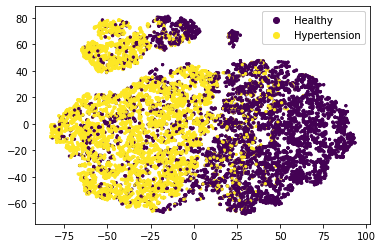

In [104]:
transformed = tsne.fit_transform(X_train)

fig, ax = plt.subplots()
scatter = ax.scatter(transformed[:,0], transformed[:,1], c=y_train, s=5)
#plt.scatter(transformed[:,0], transformed[:,1], c=y_test, s=5) #take first two columns in order to get 2d plot.


handles = scatter.legend_elements(num=[0,1,2,3])[0]  # extract the handles from the existing scatter plot

legend1 = ax.legend( handles=handles, labels=['Healthy', 'Hypertension'])

ax.add_artist(legend1)
plt.title("2D Scatter plot of training data after applying dimensionality reduction using t-SNE")
plt.show()


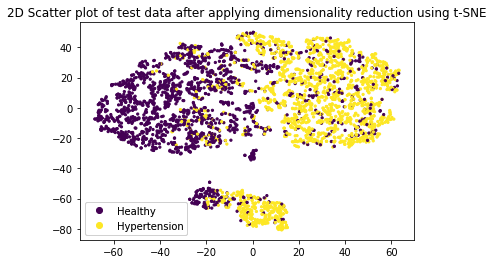

In [107]:
transformed = tsne.fit_transform(X_test)

fig, ax = plt.subplots()
scatter = ax.scatter(transformed[:,0], transformed[:,1], c=y_test, s=5)


handles = scatter.legend_elements(num=[0,1,2,3])[0]  # extract the handles from the existing scatter plot

legend1 = ax.legend( handles=handles, labels=['Healthy', 'Hypertension'])

ax.add_artist(legend1)
plt.title("2D Scatter plot of test data after applying dimensionality reduction using t-SNE")
plt.show()